# Power law example

The power in frequency bins is simulated with a power law.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from jax import jit
import jax.numpy as jnp
import jax.scipy as js
import jax.random as jr

import numpyro
import numpyro.distributions as dist
from numpyro.infer.initialization import init_to_value

from emcee.autocorr import integrated_time
import pandas as pd
from chainconsumer import ChainConsumer, Chain, Truth

from simulate_data import get_rho

## Load data

The power in each frequency bin is modeled according to the power law,

\begin{equation}
    \vec{\rho}\,(A, \gamma) = A\,\bigg(\frac{\vec{f}}{f_\text{ref}}\bigg)^{-\gamma}\;.
\end{equation}

In [2]:
# load data from dictionary and convert to jax.numpy objects
data_dict = np.load('data.npz')
times = jnp.array(data_dict['times'])
freqs = jnp.array(data_dict['freqs'])
data = jnp.array(data_dict['data'])
signal_inj = jnp.array(data_dict['signal_inj'])
hypers_inj = jnp.array(data_dict['hypers_inj'])
sigma_inj = jnp.float32(data_dict['sigma_inj'])
a_inj = jnp.array(data_dict['a_inj'])
F = jnp.array(data_dict['F'])

# derived objects
rho_inj = get_rho(*hypers_inj)
Na = a_inj.shape[0]
Nt = times.shape[0]

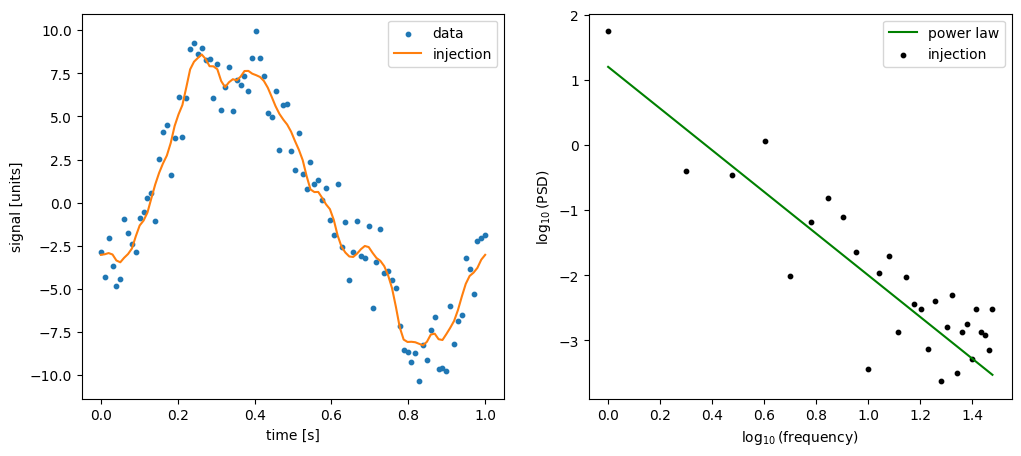

In [3]:
# plot data and injection
# time-domain
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(times, data, color='C0', s=10, label='data')
plt.plot(times, signal_inj, color='C1', label='injection')
plt.xlabel('time [s]')
plt.ylabel('signal [units]')
plt.legend()

# frequency-domain
plt.subplot(1, 2, 2)
plt.plot(jnp.log10(freqs), jnp.log10(rho_inj[::2]), color='green', label='power law')
plt.scatter(jnp.log10(freqs), jnp.log10(a_inj[::2]**2. + a_inj[1::2]**2.), color='k', s=10, label='injection')
plt.xlabel(r'$\log_{10}$(frequency)')
plt.ylabel(r'$\log_{10}$(PSD)')
plt.legend()
plt.show()

## Hierarchical model

In [4]:
# parameter bounds
hyper_mins = jnp.array([-10., 2.])
hyper_maxs = jnp.array([10., 7.])
sigma_min = 0.
sigma_max = 10.
a_min = -100.
a_max = 100.
x_mins = jnp.concatenate((hyper_mins, jnp.array([sigma_min]), jnp.array([a_min] * Na)))
x_maxs = jnp.concatenate((hyper_maxs, jnp.array([sigma_max]), jnp.array([a_max] * Na)))

# parameter labels
hyper_labels = np.array([r'$\log_{10} A$', r'$\gamma$'])
sigma_label = r'$\sigma$'
a_labels = np.array([rf'$a_{{{i // 2}}}$' if i % 2 == 0 else rf'$b_{{{i // 2}}}$'
                     for i in np.arange(2, 2 + Na)])
x_labels = np.concatenate((hyper_labels, np.array([sigma_label]), a_labels))

# injected parameters
x_inj = jnp.concatenate((hypers_inj, jnp.array([sigma_inj]), a_inj))
ndim = x_inj.shape[0]

In [5]:
# likelihood
@jit
def lnlike(sigma, a):
    # residuals
    residuals = data - F @ a
    # likelihood calculation
    return -0.5 * jnp.sum(residuals**2.) / sigma**2. - Nt * jnp.log(sigma)

## Sample hierarchical model with HMC

In [6]:
def sampling_model():
    # uniform prior on hyper-parameters
    hypers = numpyro.sample('hypers', dist.Uniform(hyper_mins, hyper_maxs))
    sigma = numpyro.sample('sigma', dist.Uniform(sigma_min, sigma_max))
    # prior on Fourier coefficients
    # a = numpyro.sample('a', dist.Normal(jnp.zeros(Na), jnp.sqrt(get_rho(*hypers))))
    a_standard = numpyro.sample('a_standard', dist.Normal().expand([Na]))
    a = numpyro.deterministic('a', a_standard * jnp.sqrt(get_rho(*hypers)))
    # likelihood
    numpyro.factor('ln_likelihood', lnlike(sigma, a))

nuts_kernel = numpyro.infer.NUTS(sampling_model,
                                 dense_mass=True)
mcmc = numpyro.infer.MCMC(sampler=nuts_kernel,
                          num_warmup=int(1e4),
                          num_samples=int(1e5))
mcmc.run(jr.key(142))
samples_dict = mcmc.get_samples()
samples = np.concatenate((samples_dict['hypers'],
                          samples_dict['sigma'][:, None],
                          samples_dict['a']), axis=1)

sample: 100%|██████████| 110000/110000 [00:41<00:00, 2670.70it/s, 15 steps of size 2.20e-01. acc. prob=0.68]


## Post-processing

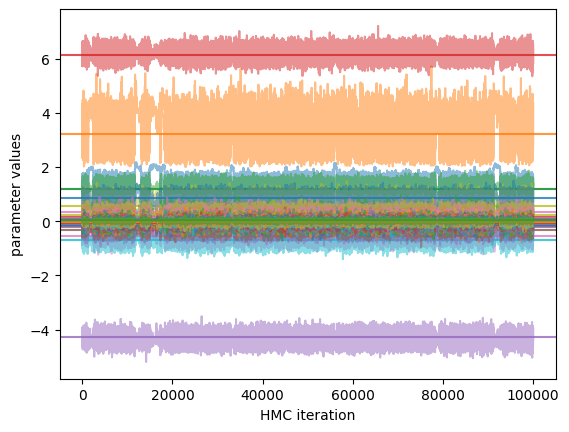

In [7]:
# trace plot
for i in range(ndim):
    plt.plot(samples[:, i], color=f'C{i}', alpha=0.5)
    plt.axhline(x_inj[i], color=f'C{i}', alpha=0.8)
plt.xlabel('HMC iteration')
plt.ylabel('parameter values')
plt.show()

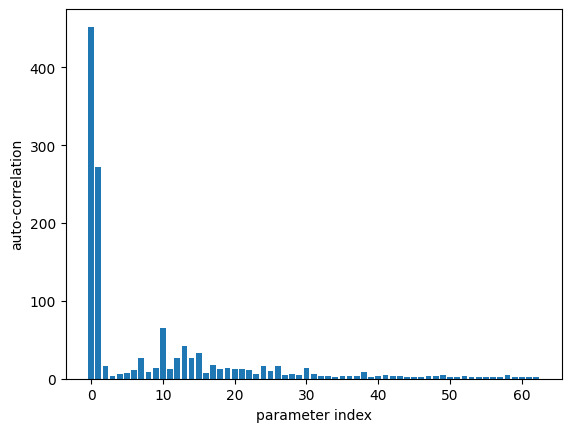

In [8]:
# plot auto-correlations of paramters
plt.bar(np.arange(ndim), np.array([integrated_time(samples[:, i])[0] for i in range(ndim)]))
plt.xlabel('parameter index')
plt.ylabel('auto-correlation')
plt.show()

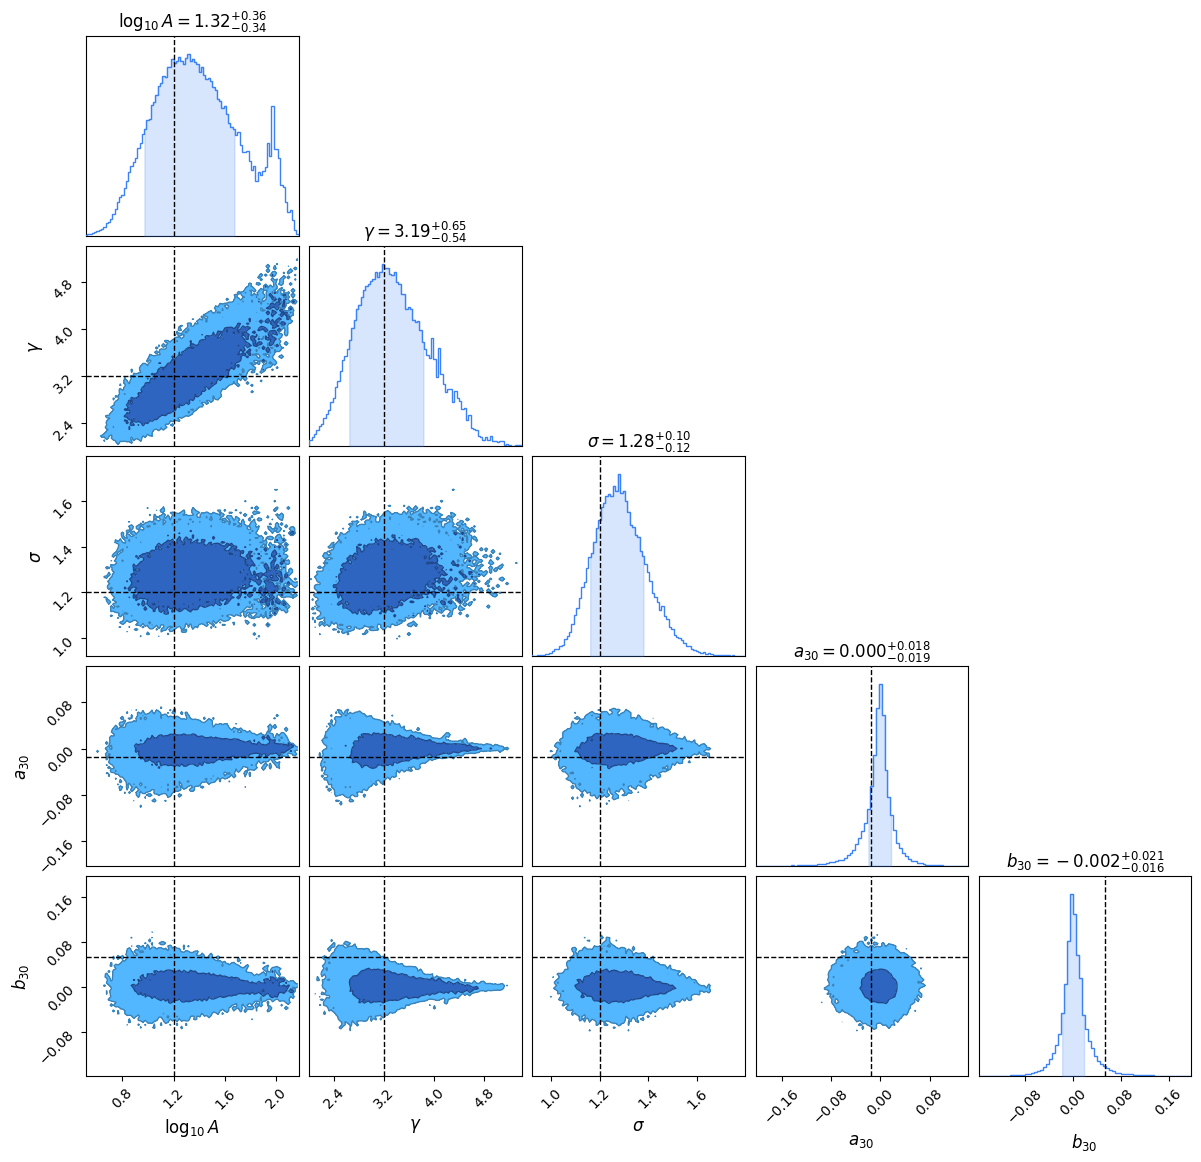

In [9]:
# posterior samples
ndxs = np.concatenate((np.r_[:3], np.r_[-2:0]))
df = pd.DataFrame(samples, columns=x_labels)
c = ChainConsumer()
c.add_chain(Chain(samples=df.iloc[:, ndxs], name='HMC', smooth=0))
c.add_truth(Truth(location={name: val for name, val in zip(x_labels, x_inj)}))
fig = c.plotter.plot()

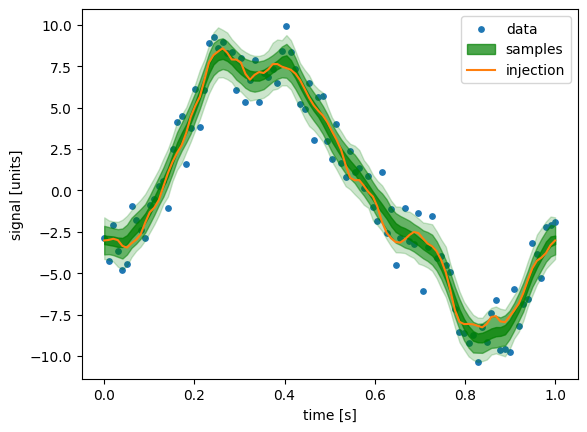

In [10]:
# signal recovery in time-domain (Bayesogram)
fair_draws_ndxs = jr.choice(jr.key(11), samples.shape[0], (1000,))
signals = np.array([F @ a for a in samples[fair_draws_ndxs, 3:]])

plt.scatter(times, data, color='C0', s=15, label='data')
plt.fill_between(times, np.percentile(signals, 0.5, axis=0), np.percentile(signals, 99.5, axis=0),
                 color='green', alpha=0.2)
plt.fill_between(times, np.percentile(signals, 5.0, axis=0), np.percentile(signals, 95., axis=0),
                 color='green', alpha=0.5)
plt.fill_between(times, np.percentile(signals, 30., axis=0), np.percentile(signals, 70., axis=0),
                 color='green', alpha=0.7, label='samples')
plt.plot(times, signal_inj, color='C1', label='injection')
plt.xlabel('time [s]')
plt.ylabel('signal [units]')
plt.legend()
plt.show()

In [11]:
# fix white noise
N = jnp.eye(Nt) * sigma_inj**2.
Ninv = jnp.eye(Nt) / sigma_inj**2.
FNF = F.T @ Ninv @ F
FNd = F.T @ Ninv @ data

# posterior using standardizing transformation
@jit
def lnpost_standard(hypers, a_standard):
    phi_diag = get_rho(*hypers)
    phi_inv = jnp.diag(1. / phi_diag)

    # posterior covariance of a
    Sigma_inv = FNF + phi_inv
    L_Sigma_inv = jnp.linalg.cholesky(Sigma_inv)
    L_inv_Sigma_inv = js.linalg.solve_triangular(L_Sigma_inv, jnp.eye(Na))
    Sigma = L_inv_Sigma_inv.T @ L_inv_Sigma_inv
    L_Sigma = js.linalg.cholesky(Sigma)

    mu = Sigma @ FNd
    a = mu + L_Sigma @ a_standard

    # if you want to cancel the standard normal prior of a_standard:
    # lnpost_val = 0.5 * jnp.sum(a_standard**2.) + 0.5 * Na * jnp.log(2*jnp.pi)
    lnpost_val = 0.5 * jnp.sum(a_standard**2.)

    # quadratic form (full Gaussian in a)
    lnpost_val -= 0.5 * a.T @ Sigma_inv @ a
    lnpost_val += a.T @ FNd
    # lnpost_val -= 0.5 * data.T @ Ninv @ data   # <-- missing constant
    

    # normalization terms
    lnpost_val -= 0.5 * jnp.sum(jnp.log(phi_diag))
    lnpost_val += jnp.sum(jnp.log(jnp.diag(L_Sigma)))  # +0.5 logdet Σ

    return lnpost_val

In [12]:
# sample with NumPyro
def standard_sampling_model():

    # draw Fourier coefficients from standard normal
    a_standard = numpyro.sample('a_standard', dist.Normal().expand((Na,)))

    # draw hyper-parameters from uniform prior
    hypers = numpyro.sample('hypers', dist.Uniform(hyper_mins, hyper_maxs))

    # posterior factor
    numpyro.factor('lnpost', lnpost_standard(hypers, a_standard))


standard_nuts_kernel = numpyro.infer.NUTS(model=standard_sampling_model,
                                          dense_mass=False,
                                        #   init_strategy=init_to_value(values={'a_standard': jnp.zeros(Na),
                                        #                                       'hypers': hypers_inj}),
                                          )
standard_mcmc = numpyro.infer.MCMC(sampler=standard_nuts_kernel,
                                   num_warmup=int(5e3),
                                   num_samples=int(1e5))
standard_mcmc.run(jr.key(12))
standard_samples_dict = standard_mcmc.get_samples()
standard_samples = np.concatenate((standard_samples_dict['hypers'],
                                   standard_samples_dict['a_standard']),
                                   axis=1)

sample: 100%|██████████| 105000/105000 [02:57<00:00, 592.41it/s, 15 steps of size 3.13e-01. acc. prob=0.91]


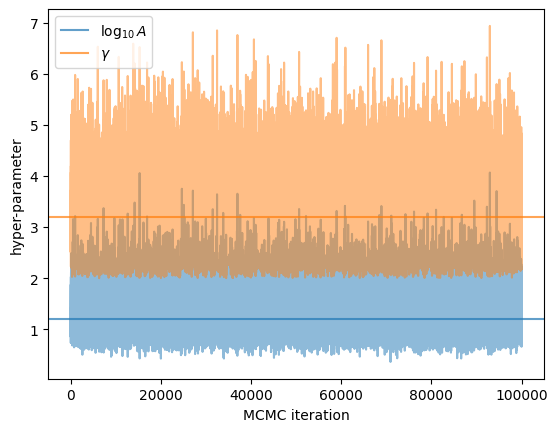

In [13]:
for i in range(2):
    plt.plot(standard_samples[:, i], color=f'C{i}', alpha=0.5)
    plt.axhline(hypers_inj[i], color=f'C{i}', alpha=0.7, label=hyper_labels[i])
plt.xlabel('MCMC iteration')
plt.ylabel('hyper-parameter')
plt.legend()
plt.show()

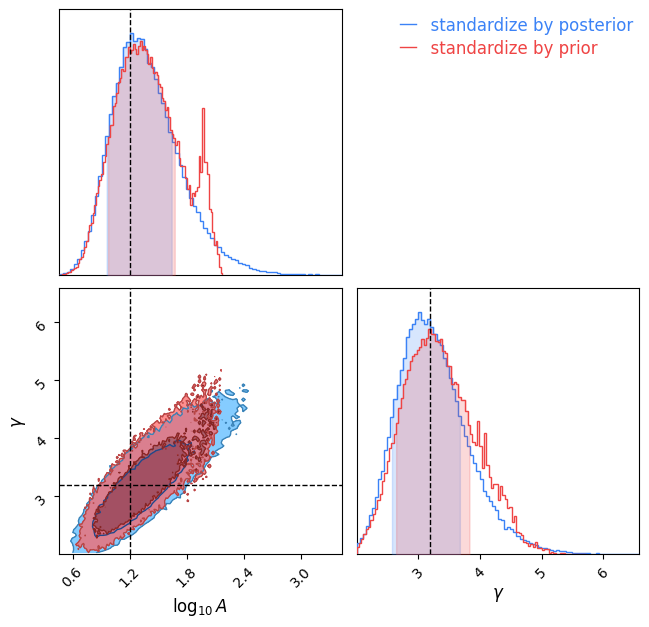

In [14]:
cc = ChainConsumer()
standard_df = pd.DataFrame(standard_samples[:, :2], columns=hyper_labels)
cc.add_chain(Chain(samples=standard_df, name='standardize by posterior', smooth=0))
cc.add_chain(Chain(samples=df.iloc[:, :2], name='standardize by prior', color='red', smooth=0))
cc.add_truth(Truth(location={name: val for name, val in zip(hyper_labels, hypers_inj)}))
fig = cc.plotter.plot()

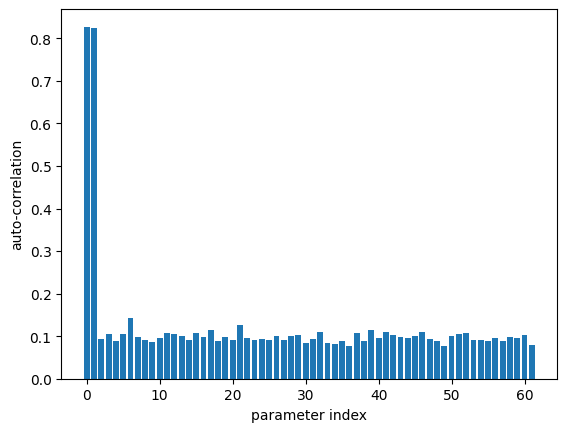

In [15]:
# plot auto-correlations of paramters
plt.bar(np.arange(ndim - 1), np.array([integrated_time(standard_samples[:, i])[0] for i in range(ndim - 1)]))
plt.xlabel('parameter index')
plt.ylabel('auto-correlation')
plt.show()

In [16]:
np.save('standard_hypers.npy', standard_samples[:, :2])
np.save('hypers.npy', samples[:, :2])